# Run the file containing the functions used in this script
## By default this is a file called "methane_functions.r" in the working directory of this script
## Do NOT change the working directory at any point while using this script.

In [73]:
# is this the folder with the script in it?
scriptDir<-getwd()
scriptDir

# if not, uncomment and use this instead
# scriptDir<-""

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane"

In [25]:
methaneFunctions<-paste(scriptDir,"/methane_functions.r",sep="")
methaneFunctions
if (file.exists(methaneFunctions)){
    source(methaneFunctions)
} else {
    print("manually correct the location and/or name of methane_functions.r")
}

[1] "/home/pleocavee/Documents/github/SensorDataProcessing/rriv_methane/methane_functions.r"

# 0. Load packages used

In [109]:
# Package names
packages <- c("dplyr", "doBy", "lubridate", "ggplot2", "Hmisc", "zoo", "viridis", "gam", "ggeffects", "reshape2", "mgcv")
packageHandler(packages)

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.


Attaching package: ‘mgcv’


The following objects are masked from ‘package:gam’:

    gam, gam.control, gam.fit, s




# 1. Locate data directory:

In [5]:
# 2023-04-25 was a startLogging run, so it has no summary lines
directory<-"~/Desktop/data/Methane Calibration/Methane_Calibration_Ian/20230425" #Ken's location

# 2. Create output directory:

In [7]:
# create output directory path based on input directory
outputDir<-paste0(directory,"_output")

# create the output directory if necessary
newDir(dirPath = outputDir)

[1] "~/Desktop/data/Methane Calibration/Methane_Calibration_Ian/20230425_output"

Output directory not found, creating: ~/Desktop/data/Methane Calibration/Methane_Calibration_Ian/20230425_output


# 3. Read in data from both RRIV and LGR
note: can separate paths for LGR and RRIV if you want, but concat_dirs should work anyways making use of the filePattern argument

In [26]:
# read_rriv_CSV eliminates debug lines and lines where the logger is NA
rriv_data<-concat_dirs(directory, read_rriv_CSV, filePattern=".CSV", minFileSize=400)

# process columns to be useful variable types, some columns may need to be done manually
rriv_data<-process_rriv_columns(rriv_data)

[1] "Dataframe generated, manually process column types if necessary"


In [125]:
# read_GA_ZIP is gas analyzer specific
lgr_data<-concat_dirs(directory, read_GA_ZIP, ".zip", 300)

# delete unzipped files
clean_temp()

# process time column from character
lgr_data$Time<-lubridate::as_datetime(lgr_data$Time)

[1] "Dataframe generated, manually process column types if necessary"


In [65]:
# range(rriv_data$time.h)

In [29]:
# names(rriv_data)

In [30]:
# str(rriv_data)

In [124]:
# str(lgr_data$Time)

# str(lgr_data$Time)

In [64]:
# range(lgr_data$Time)

# 4. Align time frames of both data sets

In [55]:
# start time is the max between the starting points for each range
start<-max(range(rriv_data$time.h)[1],range(lgr_data$Time)[1])

# end time is the min between the ending points for each range
end<-min(range(rriv_data$time.h)[2],range(lgr_data$Time)[2])

# subset the rriv data
rriv_data_overlap<-rriv_data[rriv_data$time.h>start & rriv_data$time.h<end,]
range(rriv_data_overlap$time.h)

# subset the lgr data
lgr_data_overlap<-lgr_data[lgr_data$Time>start & lgr_data$Time<end,]
range(lgr_data_overlap$Time)

[1] "2023-04-25 17:56:02 UTC" "2023-04-25 22:33:31 UTC"

[1] "2023-04-25 17:57:42 UTC" "2023-04-25 22:31:50 UTC"

# 5. Interpolate data into a new dataframe

In [134]:
# # use sequence to create minute intervals across the range of rriv_data for data points in a new dataframe
# interpolated_data<-data.frame(time_utc=seq(range(rriv_data_overlap$time.h)[1], 
#                                            range(rriv_data_overlap$time.h)[2], by = "min"))

In [163]:
# # extract time range for first data frame
# df1r<-range(rriv_data_overlap$time.h)

# # extract time range for second data frame
# df2r<-range(lgr_data_overlap$Time)

# # df1r[2]-df1r[1]
# # df2r[2]-df2r[1]

# if(df1r[2]-df1r[1] > df2r[2]-df2r[1]){
#     print("df1 time range is larger")
#     outputDF<-data.frame(time_utc=seq(df1r[1],df1r[2], by="min"))
# } else{
#     print("df2 time range is larger")
#     outputDF<-data.frame(time_utc=seq(df2r[1],df2r[2], by="min"))
# }


[1] "df1 time range is larger"


In [126]:
# names(rriv_data)
# names(lgr_data)

In [127]:
# range(rriv_data_overlap$time.h)
# range(lgr_data_overlap$Time)

In [81]:
# interpolated_data<-data.frame(time.h=seq(range(rriv_data_overlap$time.h)[1], range(rriv_data_overlap$time.h)[2], by = "min"))

In [175]:
# Manually create dictionary for column names, and what to rename them to in output df
interpolateDict<-c(
        "ch4_raw"="ch4_raw_rriv",
        "aht_C"="aht_C",
        "aht_RH"="aht_RH",
        "dht_C"="dht_C",
        "dht_RH"="dht_RH",
        "X.CH4._ppm"="ch4_ppm_lgr")

In [182]:
interpolateData<-function(df1=rriv_data_overlap, df1TimeCol="time.h",
                          df2=lgr_data_overlap, df2TimeCol="Time",
                          iDict=interpolateDict){
    iD<-iDict
    iKeys<-names(iD)
    
    # extract time range for first data frame
    df1r<-range(df1[[ df1TimeCol ]])

    # extract time range for second data frame
    df2r<-range(df2[[ df2TimeCol ]])

    # create output dataframe using whichever time range is larger
    # use sequence to create minute intervals across the range for data points in a new dataframe
    if(df1r[2]-df1r[1] > df2r[2]-df2r[1]){
        print("df1 time range is larger")
        outputDF<-data.frame(time_utc=seq(df1r[1],df1r[2], by="min"))
    } else{
        print("df2 time range is larger")
        outputDF<-data.frame(time_utc=seq(df2r[1],df2r[2], by="min"))
    }
    
    # extract column names from dataframe 1
    cols<-names(df1)

    # only interpolate data that is both in the dictionary and in the column names
    for(key in iKeys[iKeys %in% cols]){
        outputDF[[ iD[[key]] ]]<-approx(df1[[df1TimeCol]], df1[[key]], outputDF[["time_utc"]])$y
    }

    # extract column names from dataframe 2
    cols<-names(df2)

    # only interpolate data that is both in the dictionary and in the column names
    for(key in iKeys[iKeys %in% cols]){
        outputDF[[ iD[[key]] ]]<-approx(df2[[df2TimeCol]], df2[[key]], outputDF[["time_utc"]])$y
    }

    # remove lines with NA
    outputDF<-outputDF[complete.cases(outputDF),]
    
    return(outputDF)
}

In [183]:
interpolated_data<-interpolateData()

[1] "df1 time range is larger"


In [184]:
head(interpolated_data)

,time_utc,ch4_raw_rriv,aht_C,aht_RH,ch4_ppm_lgr
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>
3,2023-04-25 17:58:02,1622.914,21.52914,78.78172,478.2761
4,2023-04-25 17:59:02,1602.065,21.51935,78.80260,695.6158
5,2023-04-25 18:00:02,1579.823,21.52000,78.78734,749.2456
6,2023-04-25 18:01:02,1554.110,21.56000,78.82771,708.2048
7,2023-04-25 18:02:02,1532.608,21.55000,78.74261,670.9791
8,2023-04-25 18:03:02,1503.700,21.58850,78.61850,635.0505


In [196]:
# Calculate sensor resistance(Rs) using Figaro(manufacturer) equation
# Rs = (VC/VRL-1)*RL where
# VC = circuit voltage
# VRL = output voltage
# RL = load resistance
# 3-code 272 = 2.7kohm
RL = 2.7*1000  #convert kOhm to Ohm
VC = 5

# convert digital signal to voltage
interpolated_data$ch4_V=5/4096*interpolated_data$ch4_raw_rriv

# calculate sensor resistance (Rs)
interpolated_data$Rs_fig<-(VC/interpolated_data$ch4_V-1)*RL

# calculate absolute humidity from celsius and relative humidity
interpolated_data<-calcAbsoluteHumidity(interpolated_data,celsius = "aht_C",relativeHumidity = "aht_RH")

head(interpolated_data)

,time_utc,ch4_raw_rriv,aht_C,aht_RH,ch4_ppm_lgr,ch4_V,Rs_fig,ews_mbar,ews_kPa,aH_gm3
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,2023-04-25 17:58:02,1622.914,21.52914,78.78172,478.2761,1.981096,4114.409,13.51004,1.351004,7.826176
4,2023-04-25 17:59:02,1602.065,21.51935,78.80260,695.6158,1.955646,4203.090,13.49539,1.349539,7.820020
5,2023-04-25 18:00:02,1579.823,21.52000,78.78734,749.2456,1.928495,4300.278,13.49636,1.349636,7.819053
6,2023-04-25 18:01:02,1554.110,21.56000,78.82771,708.2048,1.897107,4416.098,13.55632,1.355632,7.856746
7,2023-04-25 18:02:02,1532.608,21.55000,78.74261,670.9791,1.870860,4515.935,13.54131,1.354131,7.839839
8,2023-04-25 18:03:02,1503.700,21.58850,78.61850,635.0505,1.835571,4654.661,13.59919,1.359919,7.859913


In [185]:
# df1<-rriv_data_overlap
# df1TimeCol<-"time.h"
# df2<-lgr_data_overlap
# df2TimeCol<-"Time"

# iD<-interpolateDict
# iK<-names(iD)

In [186]:
# # extract column names from dataframe 1
# cols<-names(df1)

# # only interpolate data that is both in the dictionary and in the column names
# for(key in iKeys[iKeys %in% cols]){
#     outputDF[[ iD[[key]] ]]<-approx(df1[[df1TimeCol]], df1[[key]], outputDF[["time_utc"]])$y
# }

# # extract column names from dataframe 2
# cols<-names(df2)

# # only interpolate data that is both in the dictionary and in the column names
# for(key in iKeys[iKeys %in% cols]){
#     outputDF[[ iD[[key]] ]]<-approx(df2[[df2TimeCol]], df2[[key]], outputDF[["time_utc"]])$y
# }

# # remove lines with NA
# outputDF<-outputDF[complete.cases(outputDF),]

In [187]:
# head(outputDF)

In [88]:
# interpolated_data$ch4_raw<-approx(rriv_data_overlap$time.h,rriv_data_overlap$ch4_raw, xout=interpolated_data$time.h)$y
# interpolated_data$aht_C<-approx(rriv_data_overlap$time.h,rriv_data_overlap$aht_C, xout=interpolated_data$time.h)$y
# interpolated_data$aht_RH<-approx(rriv_data_overlap$time.h,rriv_data_overlap$aht_RH, xout=interpolated_data$time.h)$y
# interpolated_data$CH4_ppm_lgr<-approx(lgr_data_overlap$Time,lgr_data_overlap$X.CH4._ppm, xout=interpolated_data$time.h)$y

In [188]:
# interpolated_data<-interpolated_data[complete.cases(interpolated_data),]
# head(interpolated_data)

# 6. Create Models from interpolated data
try Rs using figaro equation, relative humidity (aht_RH) -> absolute humidity

## GAM

### GAM 1: ch4_ppm_lgr ~ s(ch4_raw_rriv) + s(aht_C) + s(aht_RH)

In [199]:
gam_rriv<-mgcv::gam(ch4_ppm_lgr~s(ch4_raw_rriv)+s(aht_C)+s(aht_RH),data=interpolated_data)
summary(gam_rriv)


Family: gaussian 
Link function: identity 

Formula:
ch4_ppm_lgr ~ s(ch4_raw_rriv) + s(aht_C) + s(aht_RH)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  56.4933     0.5066   111.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                  edf Ref.df       F p-value    
s(ch4_raw_rriv) 8.947  8.998 425.332  <2e-16 ***
s(aht_C)        8.918  8.997  39.014  <2e-16 ***
s(aht_RH)       1.000  1.000   0.018   0.893    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.996   Deviance explained = 99.7%
GCV = 75.819  Scale est. = 70.322    n = 274

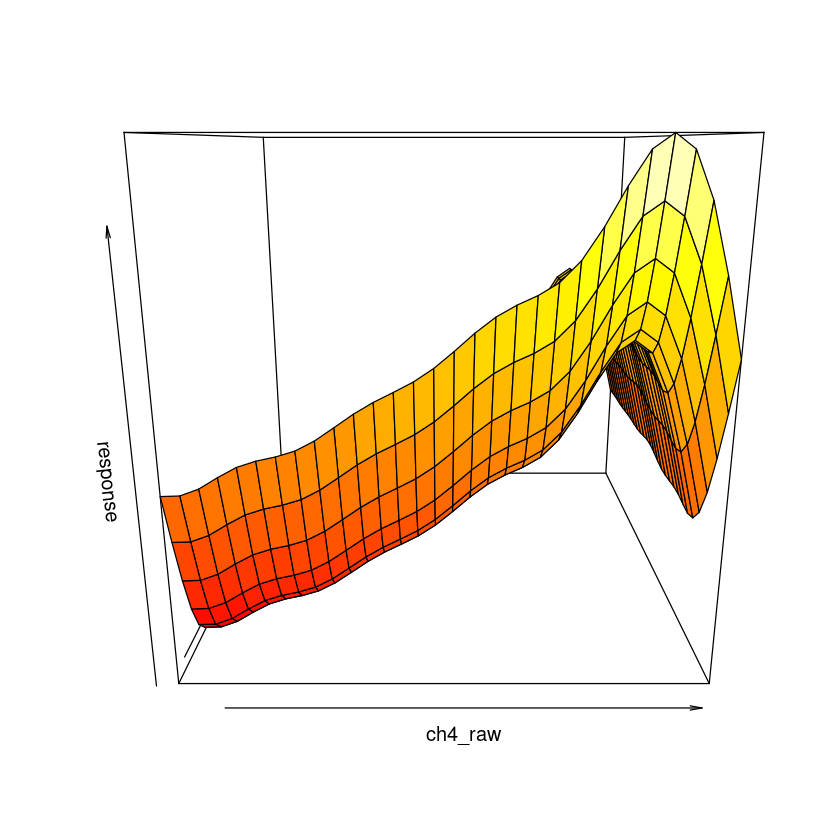

In [118]:
vis.gam(gam_rriv, type = "response", plot.type="persp")

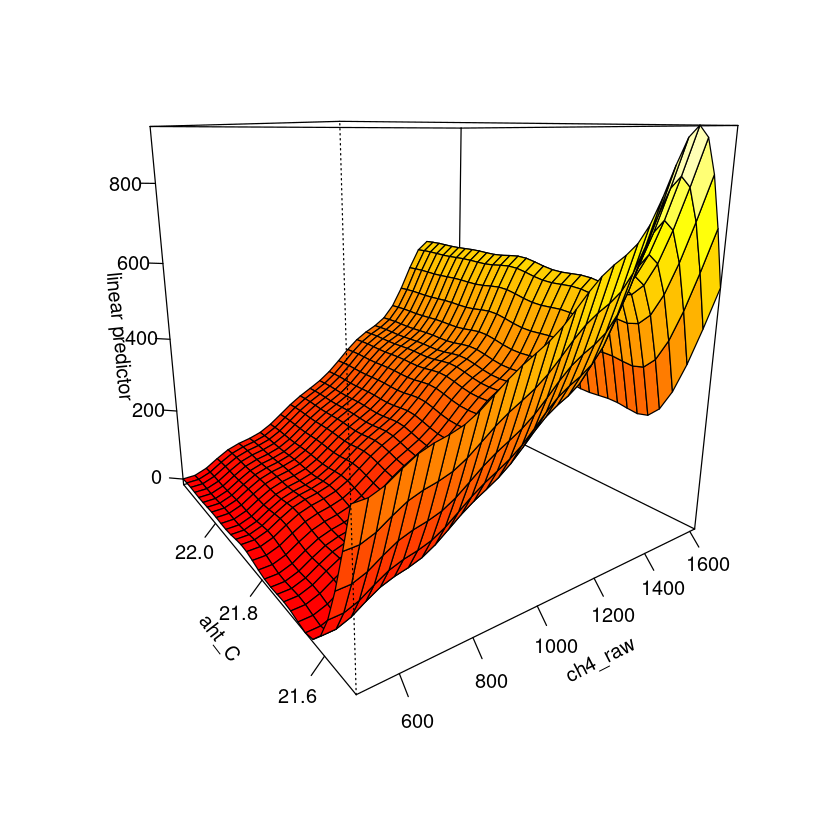

In [120]:
vis.gam(gam_rriv,ticktype="detailed",color="heat",theta=-35)

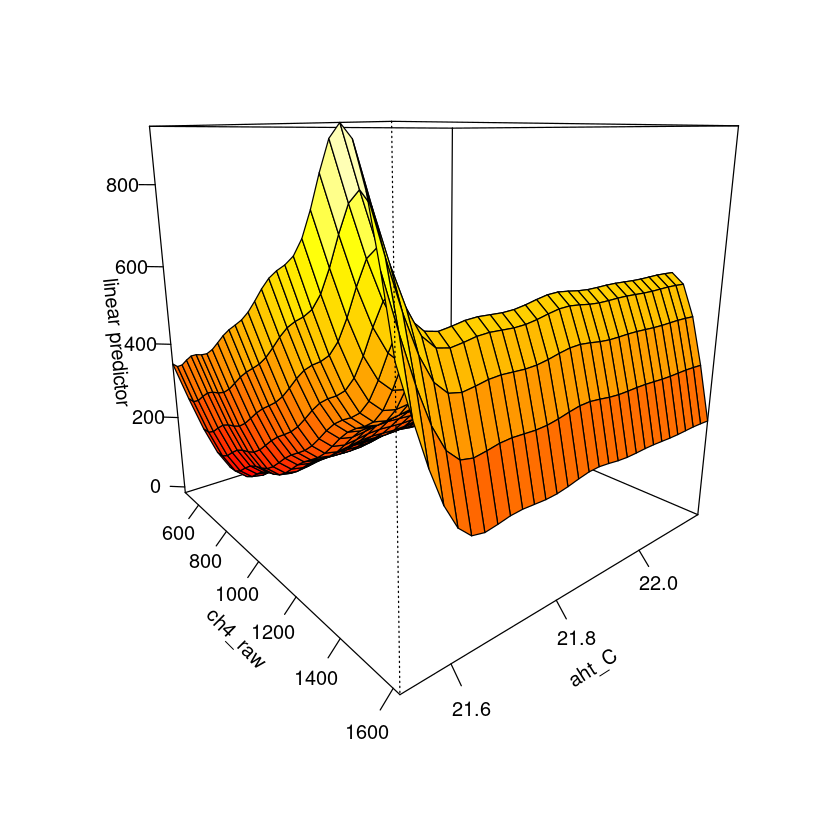

In [123]:
vis.gam(gam_rriv,ticktype="detailed",color="heat",theta=50)

In [100]:
predict(gam_rriv)->interpolated_data$predict_ch4

In [106]:
head(interpolated_data)

melted_data<-melt(interpolated_data[,c("time.h","CH4_ppm_lgr","predict_ch4")], id.vars="time.h")

,time.h,ch4_raw,aht_C,aht_RH,CH4_ppm_lgr,predict_ch4
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,2023-04-25 17:58:02,1622.914,21.52914,78.78172,478.2761,687.9932
4,2023-04-25 17:59:02,1602.065,21.51935,78.80260,695.6158,671.7959
5,2023-04-25 18:00:02,1579.823,21.52000,78.78734,749.2456,655.4124
6,2023-04-25 18:01:02,1554.110,21.56000,78.82771,708.2048,639.6396
7,2023-04-25 18:02:02,1532.608,21.55000,78.74261,670.9791,621.7912
8,2023-04-25 18:03:02,1503.700,21.58850,78.61850,635.0505,601.8198


In [107]:
head(melted_data)

,time.h,variable,value
,<dttm>,<fct>,<dbl>
1,2023-04-25 17:58:02,CH4_ppm_lgr,478.2761
2,2023-04-25 17:59:02,CH4_ppm_lgr,695.6158
3,2023-04-25 18:00:02,CH4_ppm_lgr,749.2456
4,2023-04-25 18:01:02,CH4_ppm_lgr,708.2048
5,2023-04-25 18:02:02,CH4_ppm_lgr,670.9791
6,2023-04-25 18:03:02,CH4_ppm_lgr,635.0505


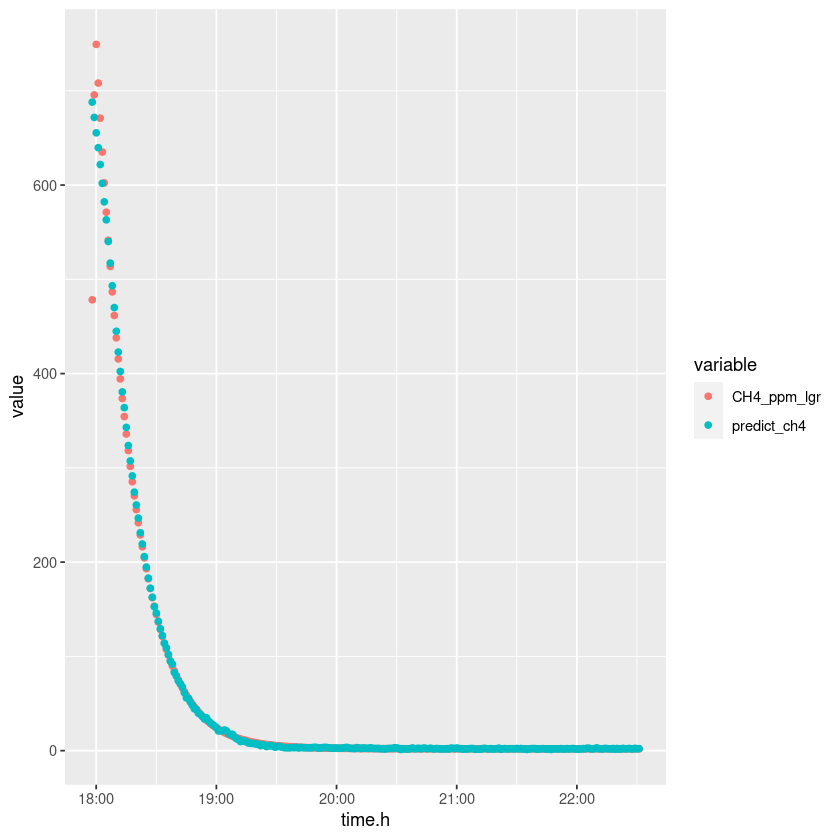

In [108]:
ggplot(data=melted_data,aes(x=time.h,y=value,color=variable))+geom_point()

### GAM 2: ch4_ppm_lgr ~ s(Rs_fig) + s(aht_C) + s(aH_gm3)

In [201]:
gam_rriv_2<-mgcv::gam(ch4_ppm_lgr~s(Rs_fig)+s(aht_C)+s(aH_gm3),data=interpolated_data)
summary(gam_rriv_2)


Family: gaussian 
Link function: identity 

Formula:
ch4_ppm_lgr ~ s(Rs_fig) + s(aht_C) + s(aH_gm3)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   56.493      0.935   60.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df        F p-value    
s(Rs_fig) 7.289  8.274 1134.063  <2e-16 ***
s(aht_C)  1.000  1.000    0.007   0.931    
s(aH_gm3) 1.000  1.000    0.018   0.893    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.988   Deviance explained = 98.8%
GCV = 248.87  Scale est. = 239.52    n = 274

### GAM 3: ch4_ppm_lgr ~ s(ch4_V) + s(aht_C) + s(aht_RH)

In [207]:
gam_rriv_3<-mgcv::gam(ch4_ppm_lgr~s(ch4_V)+s(aht_C)+s(aht_RH),data=interpolated_data)
summary(gam_rriv_3)


Family: gaussian 
Link function: identity 

Formula:
ch4_ppm_lgr ~ s(ch4_V) + s(aht_C) + s(aht_RH)

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  56.4933     0.5066   111.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
            edf Ref.df       F p-value    
s(ch4_V)  8.947  8.998 425.332  <2e-16 ***
s(aht_C)  8.918  8.997  39.014  <2e-16 ***
s(aht_RH) 1.000  1.000   0.018   0.893    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.996   Deviance explained = 99.7%
GCV = 75.819  Scale est. = 70.322    n = 274

In [197]:
names(interpolated_data)

[1] "time_utc"     "ch4_raw_rriv" "aht_C"        "aht_RH"       "ch4_ppm_lgr" 
 [6] "ch4_V"        "Rs_fig"       "ews_mbar"     "ews_kPa"      "aH_gm3"

# 4. Initial Plots

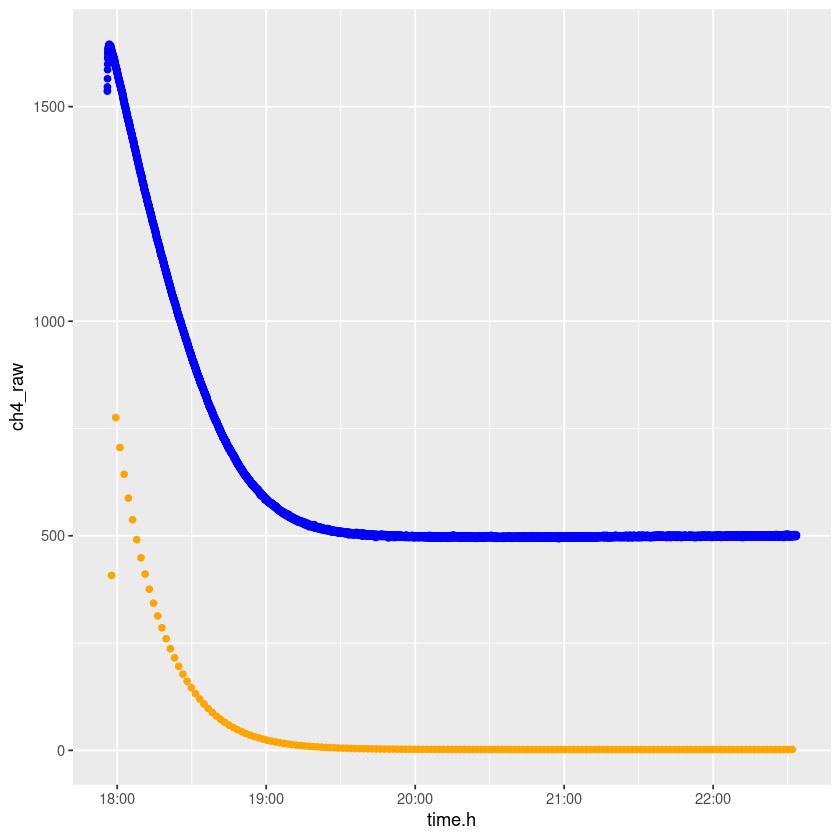

In [63]:
ggplot()+
    geom_point(data=rriv_data_overlap, aes(x=time.h,y=ch4_raw),color="blue")+
    geom_point(data=lgr_data_overlap, aes(x=Time,y=X.CH4._ppm),color="orange")

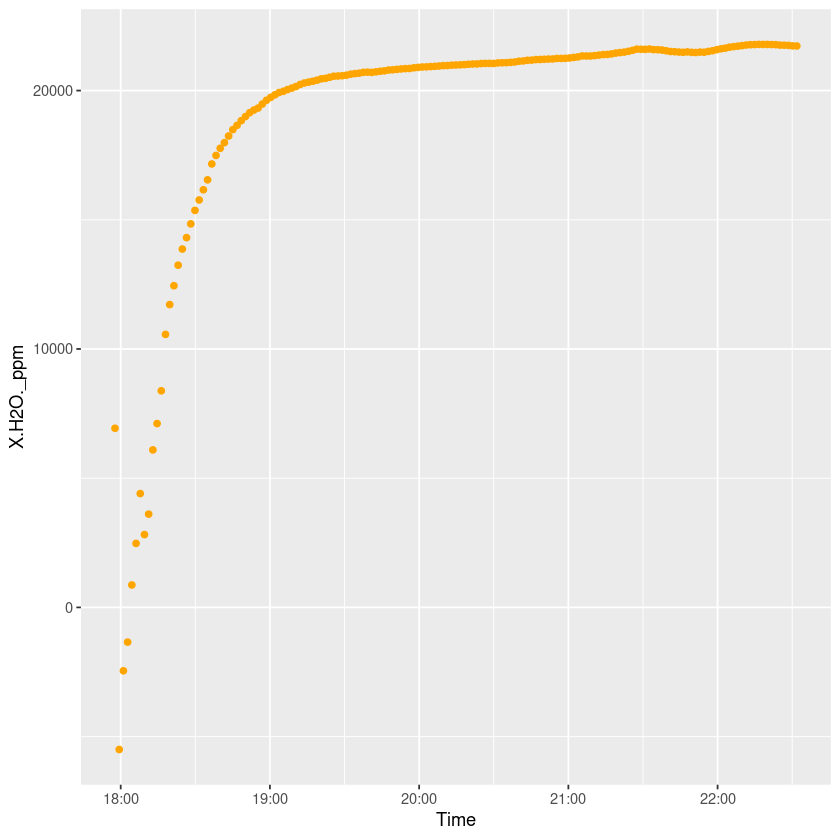

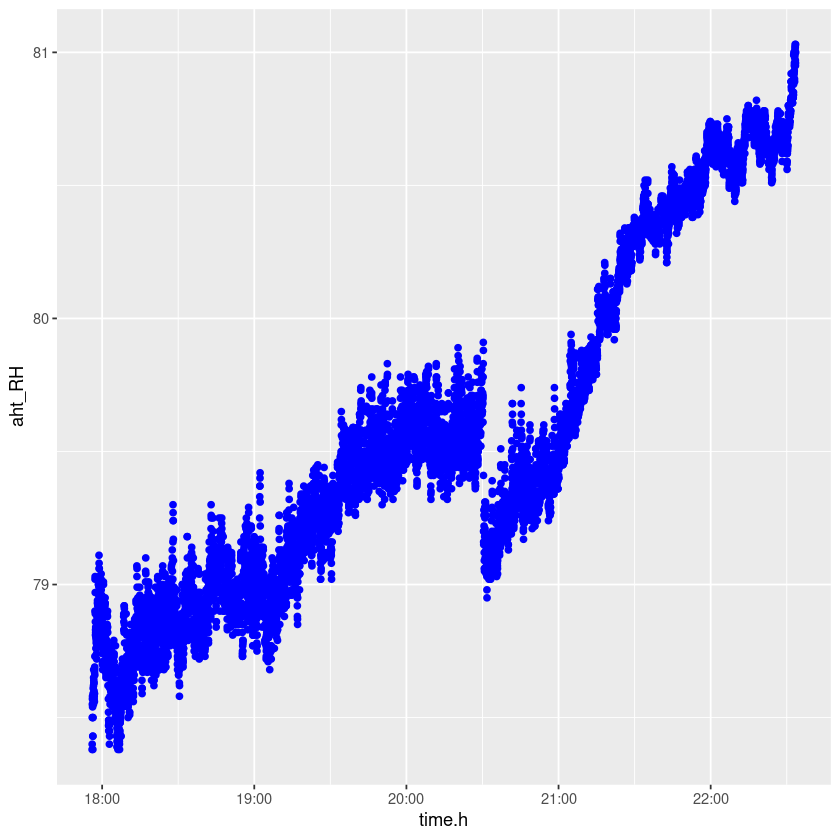

In [72]:
ggplot()+
    geom_point(data=lgr_data_overlap, aes(x=Time,y=X.H2O._ppm),color="orange")

ggplot()+
    geom_point(data=rriv_data_overlap, aes(x=time.h,y=aht_RH),color="blue")

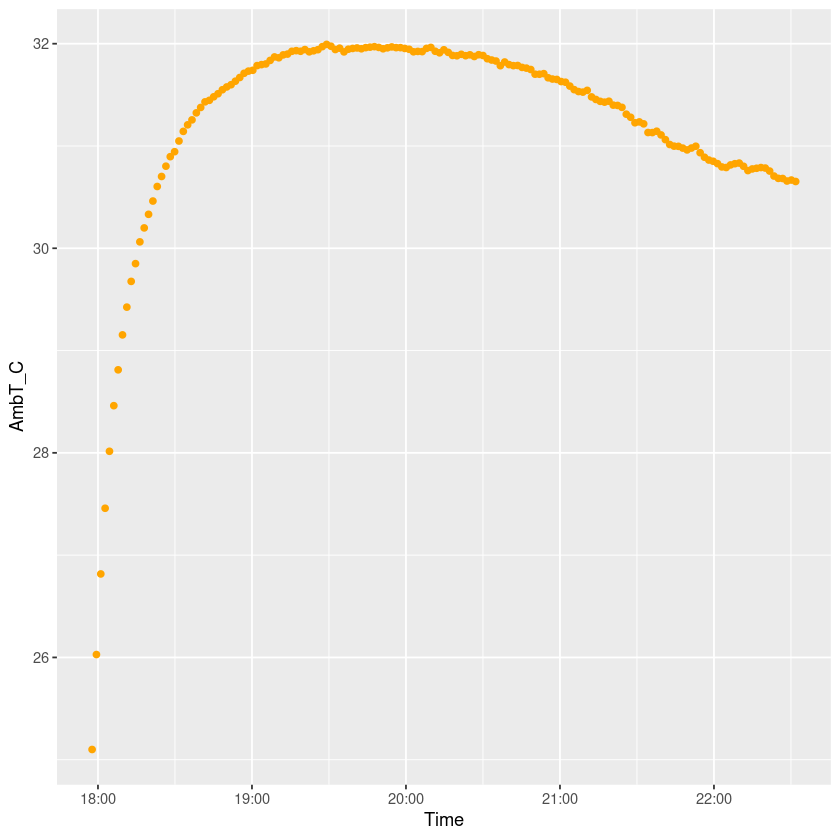

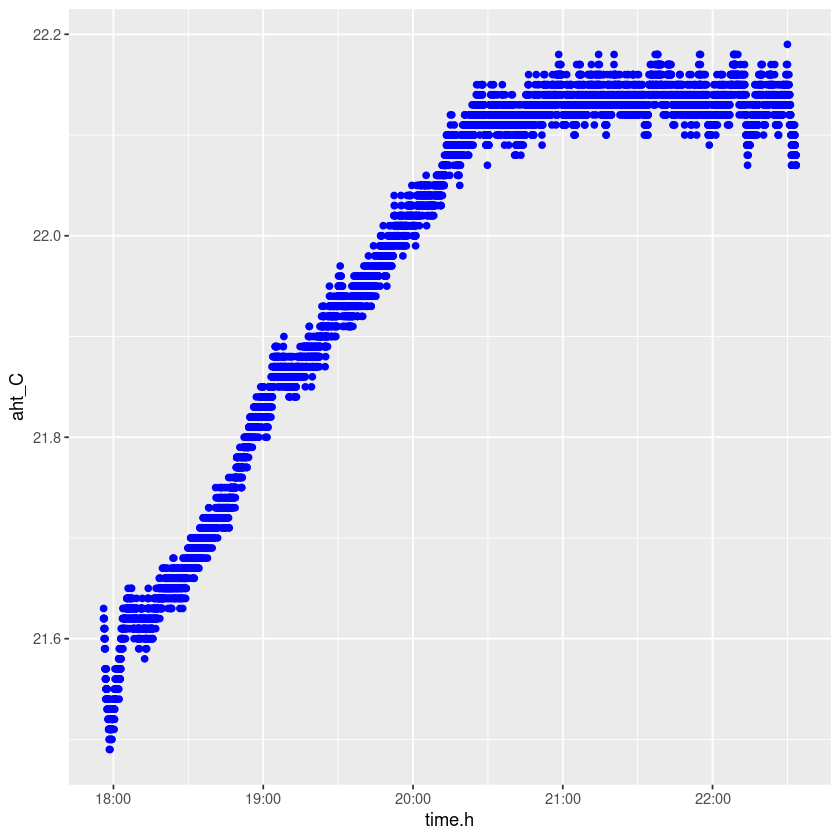

In [71]:
ggplot()+
    geom_point(data=lgr_data_overlap, aes(x=Time,y=AmbT_C),color="orange")

ggplot()+
    geom_point(data=rriv_data_overlap, aes(x=time.h,y=aht_C),color="blue")

notes:
4 resistors on NGM2611-E13 methane sensor module, can be scene on underside with 3 digit SMD code
https://kiloohm.info/smd3-resistor/272

R1 is 22kohm = 223
R2 is 6.8kOhm = 682
R3 is 6.8kOhm = 682
RL is 1.1kOhm to 4.7kohm

272 = 2.7kohm

Rs = (VC/VL-1)*RL